In [25]:
"""
Deep Q-Network Q(a, s)
-----------------------
TD Learning, Off-Policy, e-Greedy Exploration (GLIE).
Q(S, A) <- Q(S, A) + alpha * (R + lambda * Q(newS, newA) - Q(S, A))
delta_w = R + lambda * Q(newS, newA)
See David Silver RL Tutorial Lecture 5 - Q-Learning for more details.
Reference
----------
original paper: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
EN: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.5m3361vlw
CN: https://zhuanlan.zhihu.com/p/25710327
Note: Policy Network has been proved to be better than Q-Learning, see tutorial_atari_pong.py
Environment
-----------
# The FrozenLake v0 environment
https://gym.openai.com/envs/FrozenLake-v0
The agent controls the movement of a character in a grid world. Some tiles of
the grid are walkable, and others lead to the agent falling into the water.
Additionally, the movement direction of the agent is uncertain and only partially
depends on the chosen direction. The agent is rewarded for finding a walkable
path to a goal tile.
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
The episode ends when you reach the goal or fall in a hole. You receive a reward
of 1 if you reach the goal, and zero otherwise.
Prerequisites
--------------
tensorflow>=2.0.0a0
tensorlayer>=2.0.0
To run
-------
python tutorial_DQN.py --train/test
"""
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl

tl.logging.set_verbosity(tl.logging.DEBUG)

class DQNAgent():
    def __init__(self,
                  env_id='FrozenLake-v1',
                  discount_factor=0.50,
                  max_eps=1,
                  min_eps=0.1,
                  num_episodes=10000,
                  eps_decay=0.999993
                  ):
        self.env_id = env_id
        self.discount_factor = discount_factor
        self.max_eps = 1  # e-Greedy Exploration, the larger the more random
        self.min_eps = 0.1
        self.num_episodes = num_episodes
        self.render = False  # display the game environment
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.eps_decay = eps_decay
        self.q_table = np.zeros((100, 4))


    ##################### DQN ##########################


    def to_one_hot(self, i, n_classes=None):
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a


    ## Define Q-network q(a,s) that ouput the rewards of 4 actions by given state, i.e. Action-Value Function.
    # encoding for state: 10x10 grid can be represented by one-hot vector with 100 integers.
    def get_model(self, inputs_shape):
        ni = tl.layers.Input(inputs_shape, name='observation')
        nn = tl.layers.Dense(4, act=None, W_init=tf.random_uniform_initializer(0, 0.01), b_init=None, name='q_a_s')(ni)
        return tl.models.Model(inputs=ni, outputs=nn)


    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join([self.alg_name, self.env_id]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)


    def load_ckpt(self, model):  # load trained weights
        path = os.path.join('model', '_'.join([self.alg_name, self.env_id]))
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)


    def train(self, qnetwork, train_weights, optimizer, env, t0):
        flattened_map = env.desc.flatten()
        all_episode_reward = []
        for i in range(self.num_episodes):
            visited = set()
            ## Reset environment and get first new observation
            s = env.reset()[0]  # observation is state
            rAll = 0
            if self.render: env.render()
            while True:
                ## Choose an action by greedily (with e chance of random action) from the Q-network
                allQ = qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32)).numpy()
                self.q_table[s] = allQ
                a = np.argmax(allQ, 1)

                ## e-Greedy Exploration !!! sample random action
                if np.random.rand(1) < self.eps:
                    a[0] = env.action_space.sample()
                ## Get new state and reward from environment
                next_state, r, d, _, _ = env.step(a[0])

                # if flattened_map[next_state] == b'G':
                #     self.goal_reached_n += 1

                if next_state in visited:
                    r = -10
                elif next_state == s and not d:
                    r = -10
                elif flattened_map[next_state] == b'H':
                    r = -30
                elif flattened_map[next_state] == b'G':
                    r = 100
                    self.goal_reached_n += 1
                elif flattened_map[next_state] == b'F':
                    r = -1

                if self.render: env.render()

                ## Obtain the Q' values by feeding the new state through our network
                Q1 = qnetwork(np.asarray([self.to_one_hot(next_state, 100)], dtype=np.float32)).numpy()
                ## Obtain maxQ' and set our target value for chosen action.
                maxQ1 = np.max(Q1)  # in Q-Learning, policy is greedy, so we use "max" to select the next action.
                targetQ = allQ
                targetQ[0, a[0]] = r + self.discount_factor * maxQ1
                ## Train network using target and predicted Q values
                # it is not real target Q value, it is just an estimation,
                # but check the Q-Learning update formula:
                #    Q'(s,a) <- Q(s,a) + alpha(r + lambd * maxQ(s',a') - Q(s, a))
                # minimizing |r + lambd * maxQ(s',a') - Q(s, a)|^2 equals to force Q'(s,a) ≈ Q(s,a)
                with tf.GradientTape() as tape:
                    _qvalues = qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32))
                    _loss = tl.cost.mean_squared_error(targetQ, _qvalues, is_mean=False)
                grad = tape.gradient(_loss, train_weights)
                optimizer.apply_gradients(zip(grad, train_weights))

                rAll += r
                s = next_state
                
                if s not in visited:
                    visited.add(s)
                ## Reduce chance of random action if an episode is done.
                if d == True:
                    if self.eps > self.min_eps:
                        self.eps *= self.eps_decay
                    break

            ## Note that, the rewards here with random action
            if i % 10000 == 0:
                print('Training  | Episode: {}/{}  | Episode Reward: {:.4f} | Epsilon: {:.4f} | Goal reached: {}' \
                        .format(i, self.num_episodes, rAll, self.eps, self.goal_reached_n))
            if i % 100000 == 0 :
                print(self.q_table)
            if i == 0:
                all_episode_reward.append(rAll)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + rAll * 0.1)

        self.save_ckpt(qnetwork)  # save model
        print(self.q_table)
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([self.alg_name, self.env_id])))

    
    # def test(self, qnetwork, num_episodes, env, t0):
    #     self.load_ckpt(qnetwork)  # load model
    #     for i in range(num_episodes):
    #         ## Reset environment and get first new observation
    #         s = env.reset()[0]  # observation is state, integer 0 ~ 15
    #         rAll = 0
    #         if self.render: env.render()
    #         for j in range(99):  # step index, maximum step is 99
    #             ## Choose an action by greedily (with e chance of random action) from the Q-network
    #             allQ = qnetwork(np.asarray([self.to_one_hot(s, 16)], dtype=np.float32)).numpy()
    #             a = np.argmax(allQ, 1)  # no epsilon, only greedy for testing

    #             ## Get new state and reward from environment
    #             s1, r, d, _ = env.step(a[0])
    #             rAll += r
    #             s = s1
    #             if self.render: env.render()
    #             ## Reduce chance of random action if an episode is done.
    #             if d: break

    #         print('Testing  | Episode: {}/{}  | Episode Reward: {:.4f} | Running Time: {:.4f}' \
    #               .format(i, num_episodes, rAll, time.time() - t0))
    #         self.rList.append(rAll)
    #     print("Correct rate: " + str(sum(self.rList) / num_episodes * 100) + "%")


[TL] Input  observation: [None, 100]
[TL] Dense  q_a_s: 4 No Activation


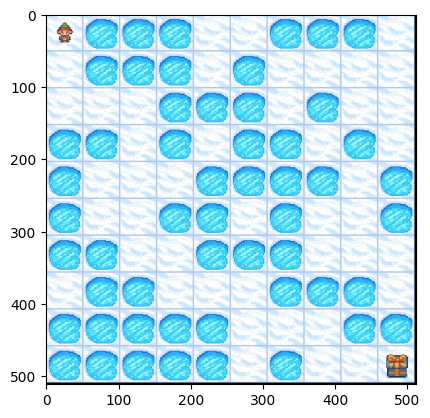

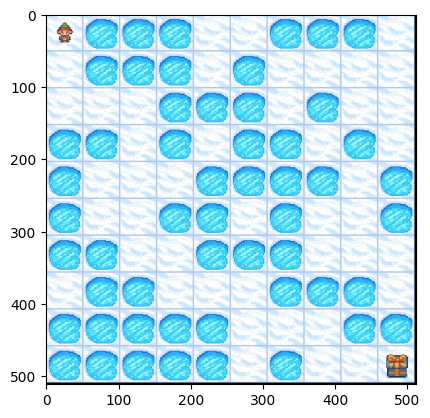

In [29]:
from gym.envs.toy_text.frozen_lake import generate_random_map


agent = DQNAgent(num_episodes=1_000_000, eps_decay=0.9999975)

qnetwork = agent.get_model([None, 100])
qnetwork.train()
train_weights = qnetwork.trainable_weights

optimizer = tf.optimizers.SGD(learning_rate=0.001)
random_map = generate_random_map(size=10, p=0.3)    

env = gym.make(agent.env_id, desc=random_map,render_mode="rgb_array")
env.reset()

t0 = time.time()
plt.imshow(env.render())
display(plt.gcf())


Training  | Episode: 0/1000000  | Episode Reward: -30.0000 | Epsilon: 1.0000 | Goal reached: 0
[[0.0078248  0.00265928 0.0044491  0.00635321]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.        

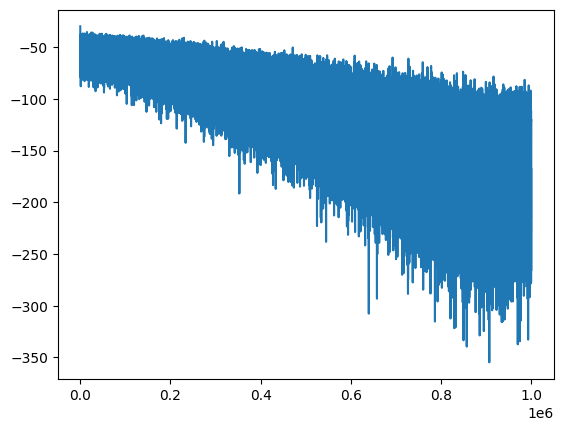

In [30]:
agent.train(qnetwork, train_weights, optimizer, env, t0)

Runs a saved Direction DQN Agent model on the environment it was trained on to record the video

In [53]:
from datetime import datetime
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD
from gym.envs.toy_text.frozen_lake import generate_random_map
from IPython.display import clear_output
import argparse
class Test_Direction_DQNAgent():
    def __init__(self,
                  env=None,
                  max_eps=1,
                  min_eps=0.1,
                  ):
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.q_table = np.zeros((100, 4))
        self.recorder = env
        self.env = env.env
        self.goal_position = np.array(np.where(self.env.desc == b'G')).flatten()
        self.position = np.array(np.where(self.env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()
        

        self.qnetwork = self.get_model([100])




    ##################### DQN ##########################
    def to_one_hot(self, i, n_classes=None):
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a


    ## Define Q-network q(a,s) that ouput the rewards of 4 actions by given state, i.e. Action-Value Function.
    # encoding for state: 10x10 grid can be represented by one-hot vector with 100 integers.
    def get_model(self,input_shape):
        #init_weights = np.hstack((np.random.uniform(0, 0.01, (100, 1)), 
        #                np.random.uniform(0.5, 0.51, (100, 1)), 
        #                np.random.uniform(0.5, 0.51, (100, 1)), 
        #                np.random.uniform(0, 0.01, (100, 1)))).astype('float32')
        
        #ni = tl.layers.Input(inputs_shape, name='observation')
        #nn = tl.layers.Dense(4, act=None, W_init=tf.constant_initializer(init_weights), b_init=None, name='q_a_s')(ni)
        #return tl.models.Model(inputs=ni, outputs=nn)
        model = Sequential([
            InputLayer(input_shape),
            Dense(4, activation='linear',use_bias=False)])
        model.compile(optimizer=SGD(learning_rate=0.1), loss=MeanSquaredError())
        return model

    
    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join(['direction', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))


    def load_ckpt(self, model, path):  # load trained weights
        
        model.load_weights(path)


    def test(self):
        done = False
        episodes = 0
        while not done:
            ## Reset environment and get first new observation
            s = self.env.reset()[0]  # observation is state
            d = False
            episodes += 1
            print(episodes)
            while d is False:
                ## Choose an action by greedily (with e chance of random action) from the Q-network
                state_basic=s
                state_arr=np.zeros(100)
                state_arr[s] = 1
                s = np.reshape(state_arr, [1, 100])
                model_output = self.qnetwork.predict(s,verbose=0)
                allQ = model_output
                self.q_table[state_basic] = allQ
                a = np.argmax(allQ)
                
                ## Get new state and reward from self.ironment
                next_state, r, d, _, _ = self.env.step(a)
                
                #clear_output(wait=True)
                #plt.imshow(self.env.render())
                self.recorder.capture_frame()
                #display(plt.gcf())
                
                
                s = next_state

                if r == 1:
                    done = True
                



In [54]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

map = ['SFFFHHHHHF','HFFFHHFFHF','HHFFHHFHHH','HFFFHFHHHF','HHFHHHHHFH','FHFFHHFHHF','FFHFFFHHHH','HHHFFFFHHH','HHHFHFFFHH','HHHHHHFFFG']
env = gym.make("FrozenLake-v1", desc=map,render_mode="rgb_array",is_slippery=True)
env.reset()

video_record = "frozenlake.mp4"
video = VideoRecorder(env,video_record)
video.frames_per_sec = 4
video.capture_frame()


np.set_printoptions(suppress=True)
agent = Test_Direction_DQNAgent(env=video)
path = "./model/direction_DQN_0.1_0.8/dqn_model.hdf5"
agent.load_ckpt(agent.qnetwork,path)
agent.test()
video.close()
env.close()

1


c:\Users\Tom Utting\Documents\School Work\Fifth Year\CS5079 Applied AI\CS5079_AppliedAI\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
MoviePy - Building video frozenlake.mp4.
MoviePy - Writing video frozenlake.mp4



MoviePy - Done !
MoviePy - video ready frozenlake.mp4
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
MoviePy - Building video frozenlake.mp4.
MoviePy - Writing video frozenlake.mp4



MoviePy - Done !
MoviePy - video ready frozenlake.mp4
